# Install needed deps

#### Don't forget to run ```apt-get update --fix-missing && sudo apt-get install build-essential``` and ```apt-get install zlib1g-dev``` in case you are running on an Ubuntu image

In [1]:
!pip install git+https://github.com/tensortrade-org/tensortrade.git
!pip install pandas-ta==0.3.14b --pre
!pip install gym==0.18.0
!pip install ipywidgets
!pip install stable-baselines3[extra]

  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-iqwx7gut
  Running command git clone --filter=blob:none --quiet https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-iqwx7gut
  Resolved https://github.com/tensortrade-org/tensortrade.git to commit 1091e33944507d9bc811b8feed080f3866a5ea04
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 42.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 KB 46.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656449 sha256=a0be2a873ae038ba1adee7709226cb05f28327978c75210f5c8de864fb86a5ce
  Stored in

# Prepare and fetch the data

In [3]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "1h")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

In [4]:
data = fetch_data()
data

,date,open,high,low,close,volume
0,2018-05-15 06:00 AM,8723.8,8793.00000,8714.900000,8739.0,8988053
1,2018-05-15 07:00 AM,8739.0,8754.80000,8719.300000,8743.0,2288904
2,2018-05-15 08:00 AM,8743.0,8743.10000,8653.200000,8723.7,8891773
3,2018-05-15 09:00 AM,8723.7,8737.80000,8701.200000,8708.1,2054868
4,2018-05-15 10:00 AM,8708.1,8855.70000,8695.800000,8784.4,17309722
...,...,...,...,...,...,...
33633,2022-03-16 08:00 PM,40904.0,41500.00000,40805.000000,41293.0,18419115
33634,2022-03-16 09:00 PM,41298.0,41428.00000,40960.000000,41130.0,4225766
33635,2022-03-16 10:00 PM,41121.0,41245.00000,40891.000000,40918.0,3326224
33636,2022-03-16 11:00 PM,40908.0,41212.68433,40807.580014,41138.0,2221451


## Create features for the feed module

In [5]:
import os
import numpy as np
import ta as ta1
import pandas_ta as ta

import quantstats as qs
qs.extend_pandas()

def fix_dataset_inconsistencies(dataframe, fill_value=None):
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = \
            dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = \
            dataframe.iloc[0,:].fillna(fill_value)

    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn',
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            #print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):

    # Generate all default indicators from ta library
    ta1.add_all_ta_features(data, 
                            'open', 
                            'high', 
                            'low', 
                            'close', 
                            'volume', 
                            fillna=True)

    # Naming convention across most technical indicator libraries
    data = data.rename(columns={'open': 'Open', 
                                'high': 'High', 
                                'low': 'Low', 
                                'close': 'Close', 
                                'volume': 'Volume'})
    data = data.set_index('date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta1.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta1.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta1.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta1.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta1.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta1.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50),
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    ## Concatenate both manually and automatically generated features
    #data = pd.concat([data, df], axis='columns').fillna(method='pad')
    #
    ## Remove potential column duplicates
    #data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    return data

In [6]:
data = generate_features(data)
# remove not needed features
to_drop = ['others_dlr', 'compsum']
data = data.drop(columns=to_drop)
data.shape

/opt/conda/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/opt/conda/lib/python3.9/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args

(33438, 141)

## Remove features with low variance before splitting the dataset

In [7]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
date = data[['date']].copy()
data = data.drop(columns=['date'])
sel.fit(data)
data[data.columns[sel.get_support(indices=True)]]
data = pd.concat([date, data], axis='columns')
data

,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,macd_normal,macd_short,macd_long,implied_volatility,outliers,pct_rank,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
0,2018-05-23 02:00 PM,7897.3,7898.80000,7849.800000,7877.4,9341499,-1.219515e+08,-153103304,-0.175983,-1.548039e+08,...,11.190548,10.871904,31.873058,0.101490,57560.0,10.000000,-0.811487,-1.144302,0.072620,-0.103251
1,2018-05-23 03:00 PM,7877.4,7889.70000,7661.000000,7700.0,23679375,-1.375548e+08,-176782679,-0.228723,-7.327921e+08,...,1.333779,-5.426751,34.355233,0.101490,57560.0,1.666667,-1.248391,-1.633909,0.079103,-0.123446
2,2018-05-23 04:00 PM,7700.0,7700.10000,7548.100000,7605.4,42144843,-1.479246e+08,-218927522,-0.216859,-1.197665e+09,...,-10.060459,-21.497215,37.504922,0.101490,57560.0,1.666667,-1.612964,-2.069373,0.080681,-0.134215
3,2018-05-23 05:00 PM,7605.4,7623.60000,7441.800000,7511.1,38711817,-1.571235e+08,-257639339,-0.221424,-1.548073e+09,...,-21.778972,-36.146245,41.269618,0.101490,57560.0,1.666667,-1.797159,-2.272346,0.082309,-0.144950
4,2018-05-23 06:00 PM,7511.1,7551.60000,7403.000000,7489.1,23046091,-1.534634e+08,-280685430,-0.149460,-1.399351e+09,...,-28.422775,-41.976877,44.917996,0.101490,57560.0,1.666667,-1.879146,-2.372706,0.082361,-0.147455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33433,2022-03-16 08:00 PM,40904.0,41500.00000,40805.000000,41293.0,18419115,1.013885e+10,-4355363275,0.116731,2.169654e+09,...,38.149126,65.400599,-183.650110,0.130710,57460.0,100.000000,0.850271,1.202045,0.124639,-0.398070
33434,2022-03-16 09:00 PM,41298.0,41428.00000,40960.000000,41130.0,4225766,1.013769e+10,-4359589041,0.104179,1.761304e+09,...,47.746927,74.844418,-192.174457,0.130295,57460.0,98.333333,0.885809,1.253852,0.124451,-0.400446
33435,2022-03-16 10:00 PM,41121.0,41245.00000,40891.000000,40918.0,3326224,1.013487e+10,-4362915265,0.068503,1.408952e+09,...,34.517432,50.137613,-197.887844,0.129894,57460.0,96.666667,0.947874,1.345862,0.124010,-0.403536
33436,2022-03-16 11:00 PM,40908.0,41212.68433,40807.580014,41138.0,2221451,1.013628e+10,-4360693814,0.201982,1.277490e+09,...,35.164301,50.363113,-205.060141,0.129979,57460.0,98.333333,0.992020,1.410359,0.124170,-0.400329


# Setup which data to use for training and which data to use for evaluation of RL Model

In [8]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.copy()
    y = X['close'].pct_change()

    X_train_test, X_valid, y_train_test, y_valid = \
        train_test_split(data, data['close'].pct_change(), train_size=0.67, test_size=0.33, shuffle=False)

    X_train, X_test, y_train, y_test = \
        train_test_split(X_train_test, y_train_test, train_size=0.50, test_size=0.50, shuffle=False)

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [9]:
X_train, X_test, X_valid, y_train, y_test, y_valid = \
    split_data(data)

## Implement basic feature engineering

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from feature_engine.selection import SelectBySingleFeaturePerformance

In [11]:
from scipy.stats import iqr

def estimate_outliers(data):
    return iqr(data) * 1.5

def estimate_percent_gains(data, column='close'):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns)
    return gains

def get_returns(data, column='close'):
    return fix_dataset_inconsistencies(data[[column]].pct_change(), fill_value=0)

def precalculate_ground_truths(data, column='close', threshold=None):
    returns = get_returns(data, column=column)
    gains = estimate_outliers(returns) if threshold is None else threshold
    binary_gains = (returns[column] > gains).astype(int)
    return binary_gains

def is_null(data):
    return data.isnull().sum().sum() > 0

def is_sparse(data, column='close'):
    binary_gains = precalculate_ground_truths(data, column=column)
    bins = [n * (binary_gains.shape[0] // n_bins) for n in range(n_bins)]
    bins += [binary_gains.shape[0]]
    bins = [binary_gains.iloc[bins[n]:bins[n + 1]] for n in range(n_bins)]
    return all([bin.astype(bool).any() for bin in bins])

def is_data_predictible(data, column):
    return not is_null(data) & is_sparse(data, column)

rf = RandomForestClassifier(n_estimators=100, 
                            random_state=1990, 
                            n_jobs=6)

sel = SelectBySingleFeaturePerformance(variables=None, 
                                       estimator=rf, 
                                       scoring="roc_auc", 
                                       cv=5, 
                                       threshold=0.65)

sel.fit(X_train, precalculate_ground_truths(X_train, column='close'))

SelectBySingleFeaturePerformance(cv=5,
                                 estimator=RandomForestClassifier(n_jobs=6,
                                                                  random_state=1990),
                                 threshold=0.65)

In [13]:
feature_performance = pd.Series(sel.feature_performance_).sort_values(ascending=False)
feature_performance

others_dr                  1.000000
lr_close                   1.000000
r_volume                   0.942063
lr_high                    0.842260
volume_vpt                 0.787310
                             ...   
trend_visual_ichimoku_b    0.342526
trend_psar_down            0.341057
trend_ichimoku_b           0.326260
volatility_dch             0.324302
volatility_dcl             0.318897
Length: 140, dtype: float64

NameError: name 'plt' is not defined

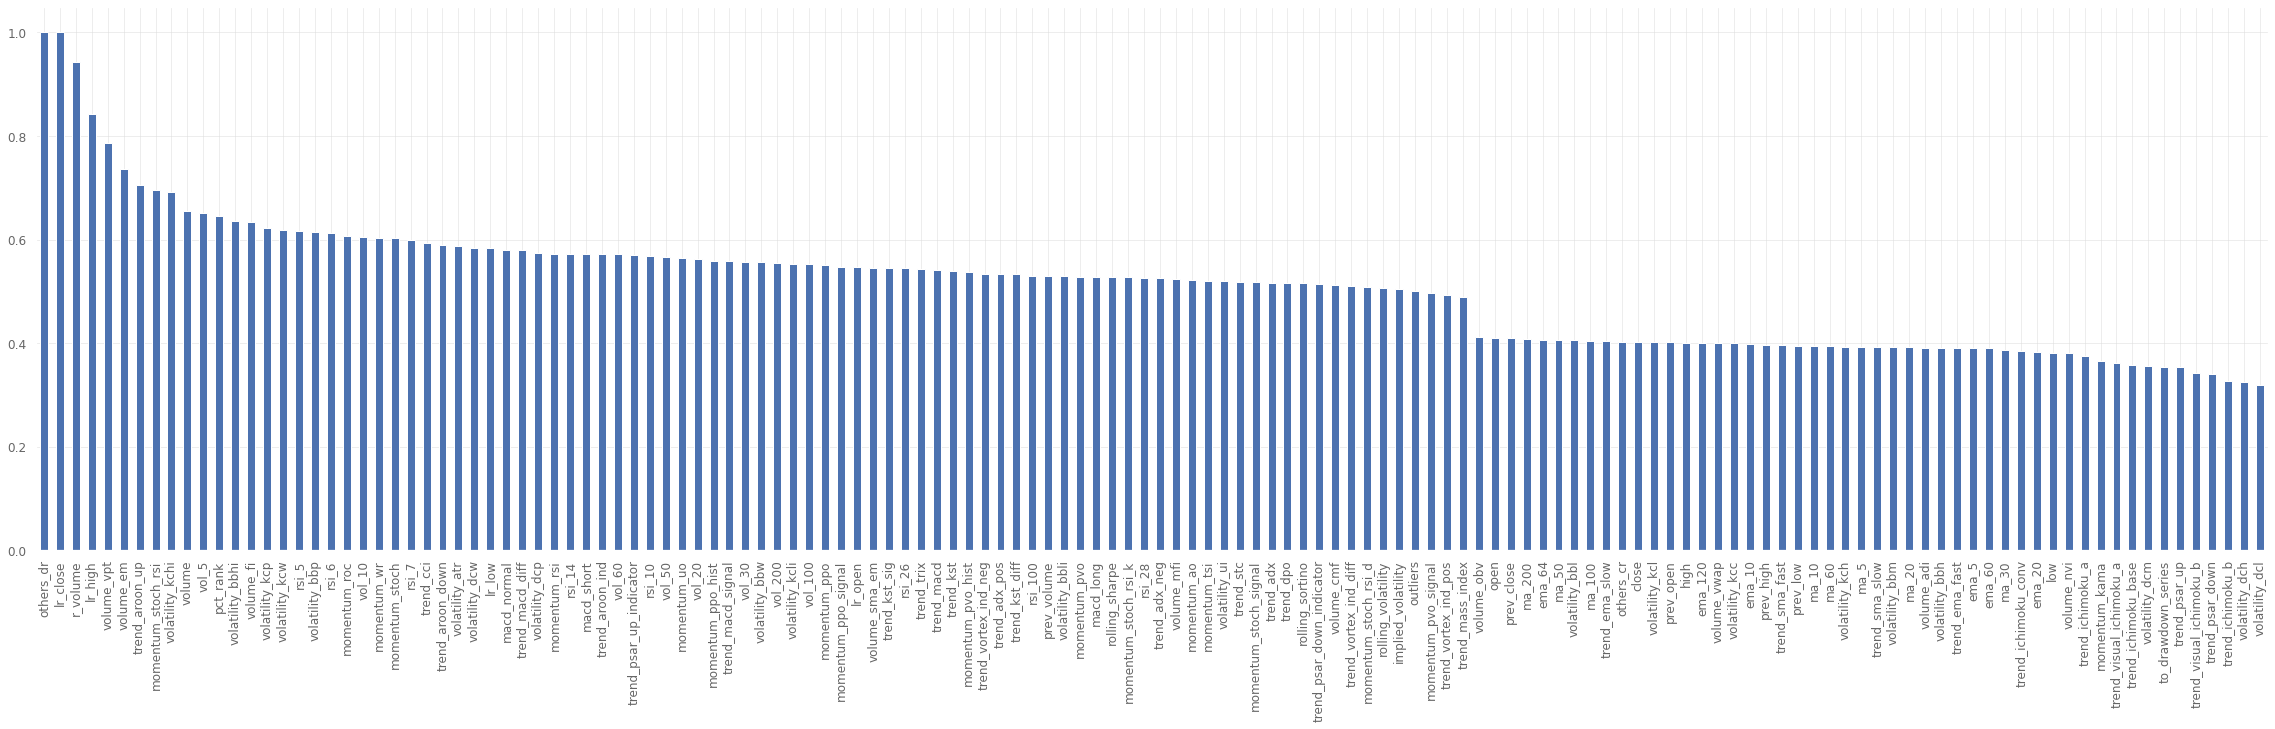

In [14]:
feature_performance.plot.bar(figsize=(40, 10))
plt.title('Performance of ML models trained with individual features')
plt.ylabel('roc-auc')

In [15]:
features_to_drop = sel.features_to_drop_
features_to_drop

['open',
 'high',
 'low',
 'close',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_sma_em',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'trend_ichimoku_b',
 'trend_stc',
 'trend_adx',
 'trend_adx_pos',
 'trend_adx_n

In [16]:
to_drop = list(set(features_to_drop) - set(['open', 'high', 'low', 'close', 'volume']))
len(to_drop)

125

In [17]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_valid = X_valid.drop(columns=to_drop)

X_train.shape, X_test.shape, X_valid.shape

((11201, 16), (11202, 16), (11035, 16))

In [18]:
X_train.columns.tolist()

['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'volume_em',
 'volume_vpt',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'others_dr',
 'vol_5',
 'lr_high',
 'lr_close',
 'r_volume']

## Normalize the dataset subsets to make the model converge faster

In [19]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler_type = MinMaxScaler

def get_feature_scalers(X, scaler_type=scaler_type):
    scalers = []
    for name in list(X.columns[X.columns != 'date']):
        scalers.append(scaler_type().fit(X[name].values.reshape(-1, 1)))
    return scalers

def get_scaler_transforms(X, scalers):
    X_scaled = []
    for name, scaler in zip(list(X.columns[X.columns != 'date']), scalers):
        X_scaled.append(scaler.transform(X[name].values.reshape(-1, 1)))
    X_scaled = pd.concat([pd.DataFrame(column, columns=[name]) for name, column in \
                          zip(list(X.columns[X.columns != 'date']), X_scaled)], axis='columns')
    return X_scaled

def normalize_data(X_train, X_test, X_valid):
    X_train_test = pd.concat([X_train, X_test], axis='index')
    X_train_test_valid = pd.concat([X_train_test, X_valid], axis='index')

    X_train_test_dates = X_train_test[['date']]
    X_train_test_valid_dates = X_train_test_valid[['date']]

    X_train_test = X_train_test.drop(columns=['date'])
    X_train_test_valid = X_train_test_valid.drop(columns=['date'])

    train_test_scalers = \
        get_feature_scalers(X_train_test, 
                            scaler_type=scaler_type)
    train_test_valid_scalers = \
        get_feature_scalers(X_train_test_valid, 
                            scaler_type=scaler_type)

    X_train_test_scaled = \
        get_scaler_transforms(X_train_test, 
                              train_test_scalers)
    X_train_test_valid_scaled = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_scalers)
    X_train_test_valid_scaled_leaking = \
        get_scaler_transforms(X_train_test_valid, 
                              train_test_valid_scalers)

    X_train_test_scaled = \
        pd.concat([X_train_test_dates, 
                   X_train_test_scaled], 
                  axis='columns')
    X_train_test_valid_scaled = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled], 
                  axis='columns')
    X_train_test_valid_scaled_leaking = \
        pd.concat([X_train_test_valid_dates, 
                   X_train_test_valid_scaled_leaking], 
                  axis='columns')

    X_train_scaled = X_train_test_scaled.iloc[:X_train.shape[0]]
    X_test_scaled = X_train_test_scaled.iloc[X_train.shape[0]:]
    X_valid_scaled = X_train_test_valid_scaled.iloc[X_train_test.shape[0]:]
    X_valid_scaled_leaking = X_train_test_valid_scaled_leaking.iloc[X_train_test.shape[0]:]

    return (train_test_scalers, 
            train_test_valid_scalers, 
            X_train_scaled, 
            X_test_scaled, 
            X_valid_scaled, 
            X_valid_scaled_leaking)

In [20]:
train_test_scalers, train_test_valid_scalers, X_train_scaled, X_test_scaled, X_valid_scaled, X_valid_scaled_leaking = \
    normalize_data(X_train, X_test, X_valid)

## Save new feature set

In [21]:
import os
cwd = os.getcwd()

train_csv = os.path.join(cwd, 'train.csv')
test_csv = os.path.join(cwd, 'test.csv')
valid_csv = os.path.join(cwd, 'valid.csv')
train_scaled_csv = os.path.join(cwd, 'train_scaled.csv')
test_scaled_csv = os.path.join(cwd, 'test_scaled.csv')
valid_scaled_csv = os.path.join(cwd, 'valid_scaled.csv')
valid_scaled_leaking_csv = os.path.join(cwd, 'valid_scaled_leaking.csv')

# Write a renderer

In [22]:
# Things to understand here:
# Writing a Renderer

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        price = list(history.close)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = price[i]
                else:
                    sell[i] = price[i] 

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(price)), price, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

# Creating the environment

In [23]:
import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.feed.core.base import NameSpace
from tensortrade.env.default.actions import BSH
from tensortrade.env.default.rewards import PBR, RiskAdjustedReturns, SimpleProfit
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.orders import TradeType

def create_env(config):
    # TODO: adjust according to your commission percentage, if present
    commission = 0.075
    price = Stream.source(list(X_train["close"]), 
                          dtype="float").rename("USD-BTC")
    bitstamp_options = ExchangeOptions(commission=commission)
    bitstamp = Exchange("bitstamp", 
                        service=execute_order, 
                        options=bitstamp_options)(price)

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0 * BTC)

    portfolio = Portfolio(USD, [cash, asset])

    with NameSpace("bitstamp"):
        features = [
            Stream.source(list(X_train_scaled[c]), 
                          dtype="float").rename(c) for c in X_train_scaled.columns[1:]
        ]

    feed = DataFeed(features)
    feed.compile()

    #reward_scheme = PBR(price=price)
    reward_scheme = SimpleProfit(window_size=config['window_size'])

    action_scheme = BSH(
        cash=cash,
        asset=asset
    )

    renderer_feed = DataFeed([
        Stream.source(list(X_train["date"])).rename("date"),
        Stream.source(list(X_train["open"]), dtype="float").rename("open"),
        Stream.source(list(X_train["high"]), dtype="float").rename("high"),
        Stream.source(list(X_train["low"]), dtype="float").rename("low"),
        Stream.source(list(X_train["close"]), dtype="float").rename("close"), 
        Stream.source(list(X_train["volume"]), dtype="float").rename("volume"), 
            Stream.sensor(action_scheme, 
                          lambda s: s.action, dtype="float").rename("action")
    ])

    renderer = [
        PositionChangeChart(),
        default.renderers.PlotlyTradingChart(
            display=True,  # show the chart on screen (default)
            height=1200,  # affects both displayed and saved file height. None for 100% height.
            include_plotlyjs = True
            
        ),
    ]

    max_allowed_loss = config["max_allowed_loss"]
    min_periods = config["window_size"]

    observer = default.observers.TensorTradeObserver(
        portfolio=portfolio,
        feed=feed,
        renderer_feed=renderer_feed,
        window_size=config['window_size'],
        min_periods=min_periods
    )

    stopper = default.stoppers.MaxLossStopper(
        max_allowed_loss=max_allowed_loss
    )

    informer = default.informers.TensorTradeInformer()

    random_start_pct = 0.0

    env = default.create(
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        feed=feed,
        renderer_feed=renderer_feed,
        renderer=renderer,
        observer=observer,
        stopper=stopper,
        informer=informer,
        min_periods=min_periods,
        random_start_pct=random_start_pct,
        window_size=config['window_size']
    )
    
    return env

In [24]:
%xmode Plain
%pdb on

Exception reporting mode: Plain
Automatic pdb calling has been turned ON


# Create the training environment and the training model

In [25]:
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy


cwd = os.getcwd()
logdir = "logs"
if not os.path.exists(logdir):
    os.makedirs(logdir)
models_dir = "models/PPO"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

env_config_training = {
    "window_size": 14,  # We want to look at the last 14 samples (hours)
    "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
    "max_allowed_loss": 0.10,  # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
}

env = Monitor(create_env(env_config_training))

model = PPO(MlpPolicy, env, verbose=1, tensorboard_log=logdir)
env.observer.feed.next()

Using cpu device
Wrapping the env in a DummyVecEnv.


{'internal': {'bitstamp:/USD-BTC': 7716.3,
  'bitstamp:/USD:/free': 10000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 10000.0,
  'bitstamp:/BTC:/free': 0.0,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.0,
  'bitstamp:/BTC:/worth': 0.0,
  'net_worth': 10000.0},
 'external': {'bitstamp:/open': 0.2641794289579207,
  'bitstamp:/high': 0.26762982602086305,
  'bitstamp:/low': 0.26777629508132916,
  'bitstamp:/close': 0.27098609584324906,
  'bitstamp:/volume': 0.09345097877973157,
  'bitstamp:/volume_em': 0.0028704113591117904,
  'bitstamp:/volume_vpt': 0.5477862319086588,
  'bitstamp:/volatility_kchi': 1.0,
  'bitstamp:/trend_aroon_up': 0.08333333333333334,
  'bitstamp:/momentum_stoch_rsi': 1.0,
  'bitstamp:/others_dr': 0.5047918061423396,
  'bitstamp:/vol_5': 0.08559712953139922,
  'bitstamp:/lr_high': 0.5145021469753617,
  'bitstamp:/lr_close': 0.550842518509197,
  'bitstamp:/r_volume': 0.6427777263040861},
 'renderer': {'date': '2018-05-24 04:00 AM',
  'ope

# Run an evaluation test to demonstrate random agent vs trained agent

In [26]:
# env_config_evaluation = {
#     "window_size": 14,  # We want to look at the last 14 samples (hours)
#     "reward_window_size": 7,  # And calculate reward based on the actions taken in the next 7 hours
#     "max_allowed_loss": 1.00,  # During validation runs we want to see how bad it would go. Even up to 100% loss.
#     "csv_filename": os.path.join(cwd, 'evaluation.csv'),  # The variable that will be used to differentiate training and validation datasets
# }
# Use a separate environement for evaluation
# eval_env = Monitor(create_env(env_config_evaluation))

# Random Agent, before training
# mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=14)
# print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

# Train a PPO model and save it after each x steps with stable lines

In [27]:
# it will save a model at each 10k steps. this helps us to choose the best one
TIMESTEPS = 10000
iters = 0
while True:
    iters += 1
    
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

Logging to logs/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.42     |
|    ep_rew_mean     | -0.277   |
| time/              |          |
|    fps             | 539      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.68        |
|    ep_rew_mean          | -0.261      |
| time/                   |             |
|    fps                  | 441         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019452598 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.677      |
|    explained_variance   | -0.2        |
|    lea

KeyboardInterrupt: 

> /opt/conda/lib/python3.9/site-packages/tensortrade/feed/core/base.py(536)forward()
    534         v = self.current
    535         try:
--> 536             self.current = next(self.generator)
    537         except StopIteration:
    538             self.stop = True



ipdb>  q


# Load saved model

In [28]:
%matplotlib inline

In [34]:
# Make sure to load the model that performed the best, you can check it up in the tensorboard
# usualy it's the one with the highest rollout/ep_rew_mean, you can identify it by looking at the step number
model_path = f"{models_dir}/380000"
model = PPO.load(model_path, env=env)

Wrapping the env in a DummyVecEnv.


# Render results

In [35]:

steps = 10000
render_interval = steps // 10
obs = env.reset()
for i in range(steps):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.env.step(action)
    # if (i % render_interval) == 0:
    #     env.env.render()
    # if done:
    #     obs = env.reset()

/tmp/ipykernel_13431/2864134326.py:32: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_13431/2864134326.py:33: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



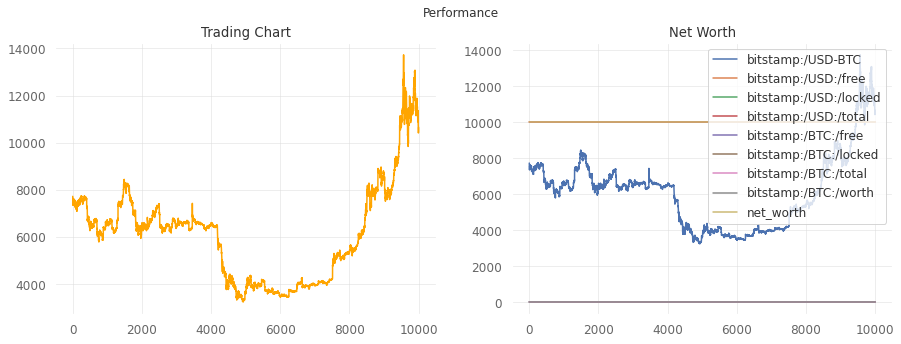

FigureWidget({
    'data': [{'close': array([ 7716.3 ,  7680.5 ,  7639.9 , ..., 10495.95, 10633.  , 10650.  ])…

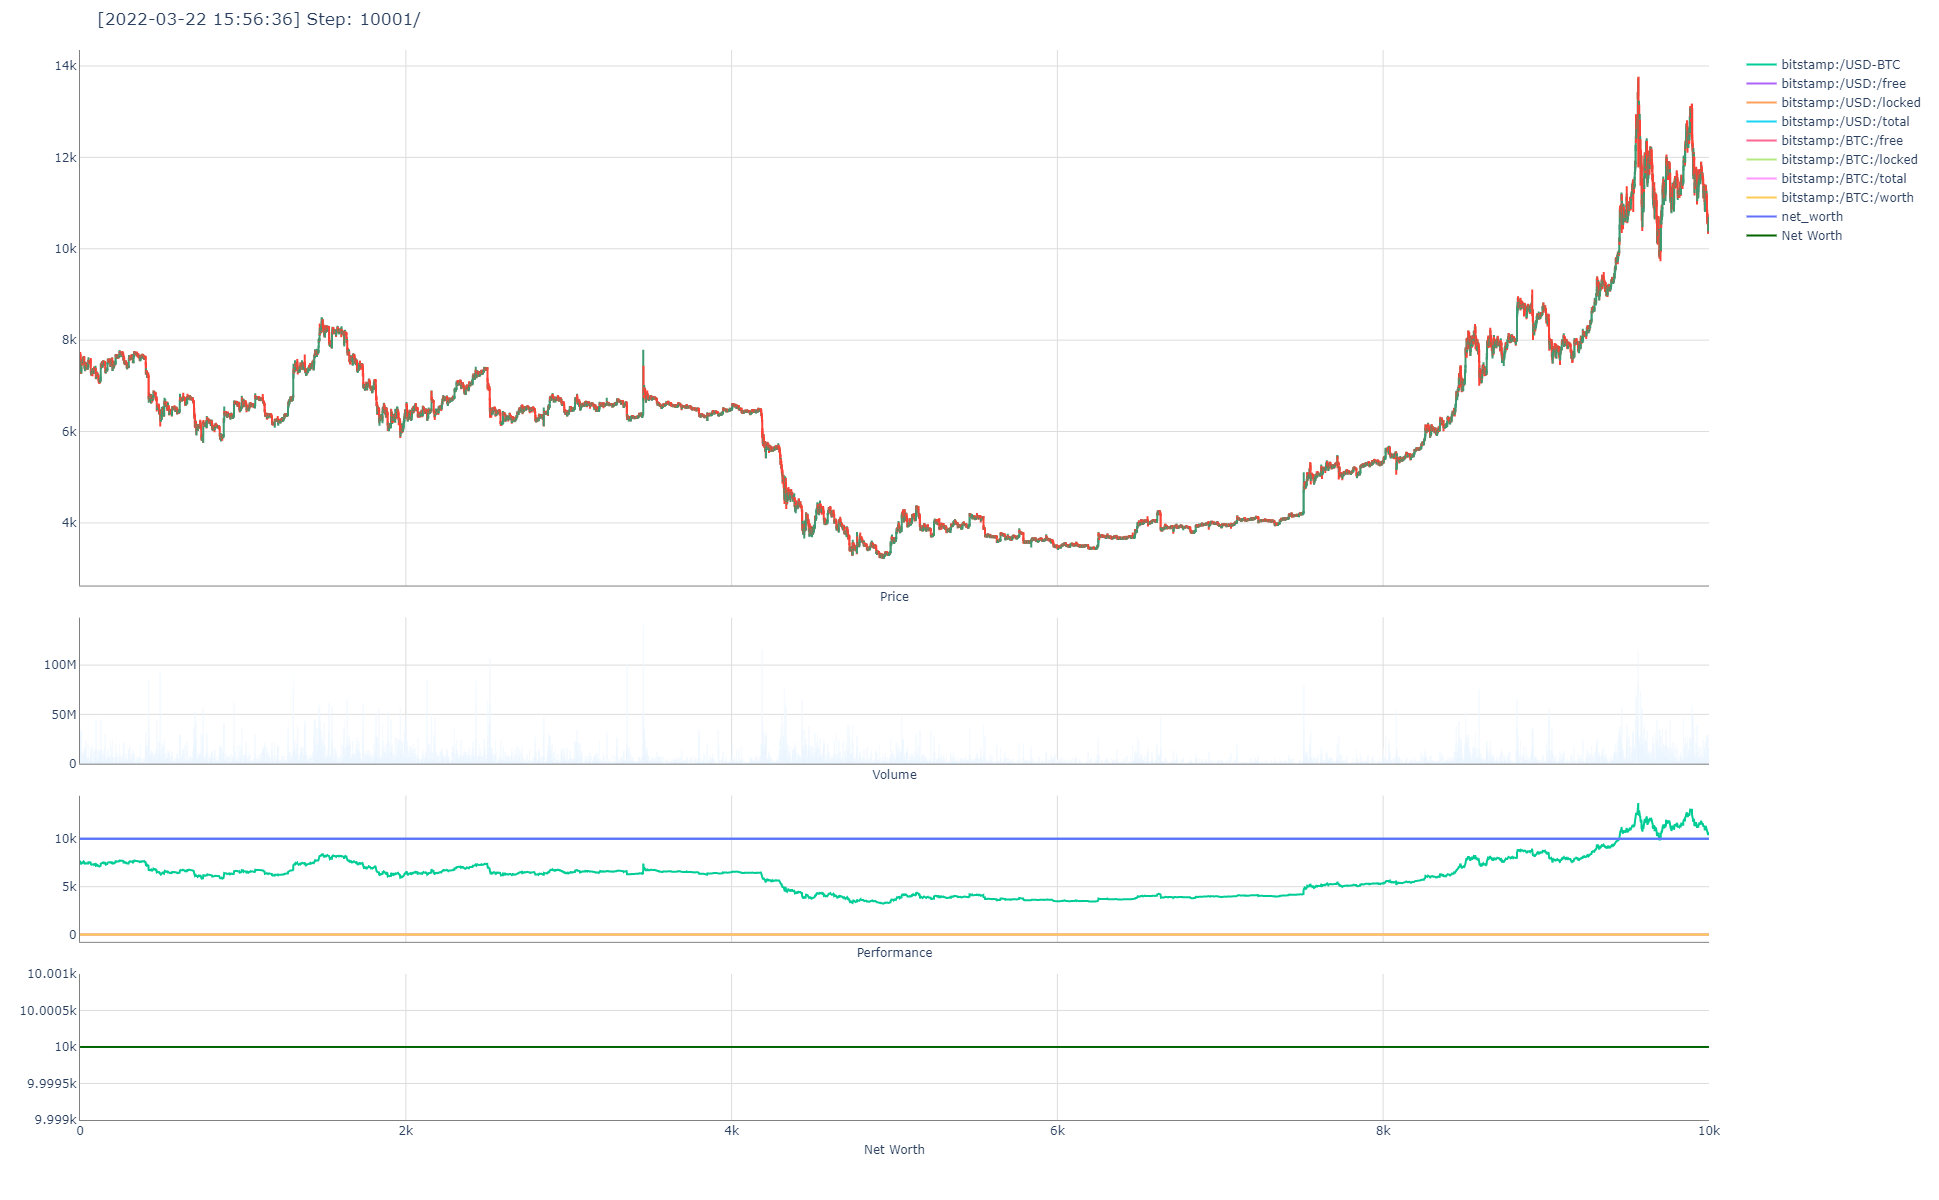

In [36]:
env.env.render()